In [1]:
#*******Importing Libraries.
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
print(sc.version)
print(spark.version)
#********PySpark connect


#************Importing other functions
from pyspark.sql.functions import *

import re
    
#Importing Matplotlib. 
import matplotlib.pyplot as plt
%matplotlib inline

2.4.7
2.4.7


In [2]:
# Increasing the width of the page.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
#Reading CSV to Spark dataframe
Sales = spark.read.options(header='True', inferSchema='True') \
  .csv("O:/MS/ECE552/Final_Project/1500000 Sales Records/1500000 Sales Records.csv")

In [4]:
Sales.show(5)

+--------------------+----------------+---------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|              Region|         Country|Item Type|Sales Channel|Order Priority|Order Date| Order ID| Ship Date|Units Sold|Unit Price|Unit Cost|Total Revenue|Total Cost|Total Profit|
+--------------------+----------------+---------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|  Sub-Saharan Africa|    South Africa|   Fruits|      Offline|             M| 7/27/2012|443368995| 7/28/2012|      1593|      9.33|     6.92|     14862.69|  11023.56|     3839.13|
|Middle East and N...|         Morocco|  Clothes|       Online|             M| 9/14/2013|667593514|10/19/2013|      4611|    109.28|    35.84|    503890.08| 165258.24|   338631.84|
|Australia and Oce...|Papua New Guinea|     Meat|      Offline|             M| 5/15/2015|940995

In [5]:
# Printing Sales columns
Sales.columns

['Region',
 'Country',
 'Item Type',
 'Sales Channel',
 'Order Priority',
 'Order Date',
 'Order ID',
 'Ship Date',
 'Units Sold',
 'Unit Price',
 'Unit Cost',
 'Total Revenue',
 'Total Cost',
 'Total Profit']

In [6]:
# Checking Null values. 

In [7]:
Sales.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Sales.columns]).show()

+------+-------+---------+-------------+--------------+----------+--------+---------+----------+----------+---------+-------------+----------+------------+
|Region|Country|Item Type|Sales Channel|Order Priority|Order Date|Order ID|Ship Date|Units Sold|Unit Price|Unit Cost|Total Revenue|Total Cost|Total Profit|
+------+-------+---------+-------------+--------------+----------+--------+---------+----------+----------+---------+-------------+----------+------------+
|     0|      0|        0|            0|             0|         0|       0|        0|         0|         0|        0|            0|         0|           0|
+------+-------+---------+-------------+--------------+----------+--------+---------+----------+----------+---------+-------------+----------+------------+



In [8]:
# Replacing spaces in column names with "_" for converting into parquet form. 
Sales = Sales.select([col(c).alias(re.sub("[^0-9a-zA-Z$]+","_",c)) for c in Sales.columns])

In [9]:
# Printing column names.
Sales.columns

['Region',
 'Country',
 'Item_Type',
 'Sales_Channel',
 'Order_Priority',
 'Order_Date',
 'Order_ID',
 'Ship_Date',
 'Units_Sold',
 'Unit_Price',
 'Unit_Cost',
 'Total_Revenue',
 'Total_Cost',
 'Total_Profit']

In [ ]:
# Converting CSV to paraquet

Sales.write.parquet("O:/MS/ECE552/Final_Project/1500000 Sales Records/1500000 Sales Records.parquet")

In [10]:
# Reading Parquet file 
par_Sales = spark.read.parquet("O:/MS/ECE552/Final_Project/1500000 Sales Records/1500000 Sales Records.parquet")


In [11]:
# Printing number of rows and schema.
print(par_Sales.count())
par_Sales.printSchema()

1500000
root
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Item_Type: string (nullable = true)
 |-- Sales_Channel: string (nullable = true)
 |-- Order_Priority: string (nullable = true)
 |-- Order_Date: string (nullable = true)
 |-- Order_ID: integer (nullable = true)
 |-- Ship_Date: string (nullable = true)
 |-- Units_Sold: integer (nullable = true)
 |-- Unit_Price: double (nullable = true)
 |-- Unit_Cost: double (nullable = true)
 |-- Total_Revenue: double (nullable = true)
 |-- Total_Cost: double (nullable = true)
 |-- Total_Profit: double (nullable = true)



In [12]:
# Creating a view for SQL Opereations
par_Sales.createOrReplaceTempView("par_Sales")

# Queries and Visualizations.

###### Top 10 countries having the highest revenue in Beverages?

In [13]:
# SQL Query

%time

High_revenue_in_Beverages = spark.sql("SELECT Country,  sum(Total_Revenue) AS Beverages_Revenue FROM par_Sales WHERE Item_Type = 'Beverages' GROUP BY Country  ORDER BY 2 DESC LIMIT 10")
High_revenue_in_Beverages.show()

Wall time: 0 ns
+--------------+--------------------+
|       Country|   Beverages_Revenue|
+--------------+--------------------+
|United Kingdom|        1.75227156E8|
|       Finland|       1.731624167E8|
|       Albania|       1.722891469E8|
|        Serbia|1.7206793500000003E8|
|       Namibia|1.7203918029999998E8|
|         Spain|      1.7191661695E8|
|  Saudi Arabia|1.7130845029999998E8|
|        Kosovo|1.7056059085000002E8|
|     Indonesia|       1.703835549E8|
|      Ethiopia|      1.7011142915E8|
+--------------+--------------------+



In [14]:
# Count of rows
High_revenue_in_Beverages.count()

10

In [15]:
# Converting to pandas dataframe.
Beverages = High_revenue_in_Beverages.toPandas()

In [16]:
# Seting Index
Beverages.set_index('Country', inplace=True)

(170000000.0, 176000000.0)

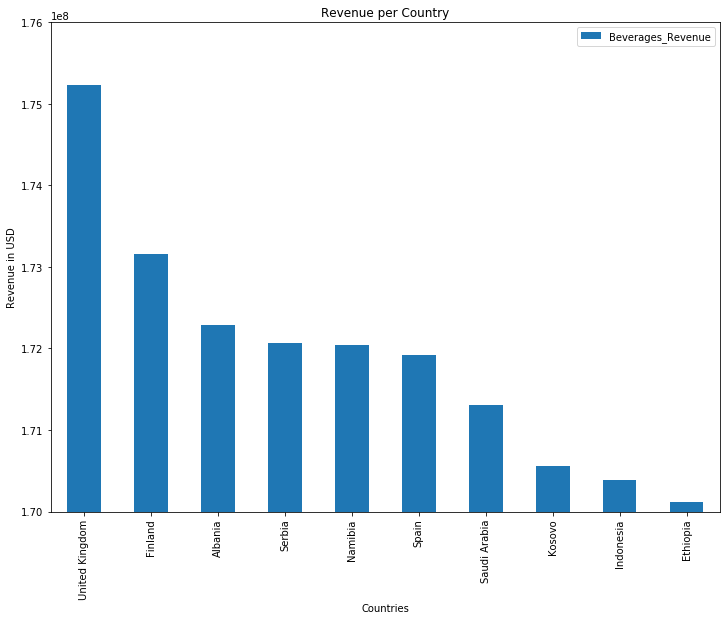

In [17]:
# Visualization
BeveragesperCountry = Beverages.plot(kind='bar',figsize=(12,9),rot = 90,title = "Revenue per Country")
BeveragesperCountry.set_xlabel("Countries")
BeveragesperCountry.set_ylabel("Revenue in USD")
BeveragesperCountry.set_ylim(bottom = 1.7E8, top = 1.76E8)

###### Total profit for different sales channel. 

In [18]:
#SQL Query
Sales_channel_revenue = spark.sql("SELECT Sales_Channel, Item_Type, max(Total_Profit) AS Profit FROM par_Sales GROUP BY Sales_Channel, Item_Type  ORDER BY Sales_Channel DESC, Item_Type ASC")
Sales_channel_revenue.show(25)

+-------------+---------------+---------+
|Sales_Channel|      Item_Type|   Profit|
+-------------+---------------+---------+
|       Online|      Baby Food| 958600.0|
|       Online|      Beverages| 156600.0|
|       Online|         Cereal| 885900.0|
|       Online|        Clothes| 734400.0|
|       Online|      Cosmetics|1738700.0|
|       Online|         Fruits|  24100.0|
|       Online|      Household|1657300.0|
|       Online|           Meat| 572000.0|
|       Online|Office Supplies|1262500.0|
|       Online|  Personal Care| 250600.0|
|       Online|         Snacks| 551400.0|
|       Online|     Vegetables| 631300.0|
|      Offline|      Baby Food| 958600.0|
|      Offline|      Beverages| 156600.0|
|      Offline|         Cereal| 885900.0|
|      Offline|        Clothes| 734400.0|
|      Offline|      Cosmetics|1738700.0|
|      Offline|         Fruits|  24100.0|
|      Offline|      Household|1657300.0|
|      Offline|           Meat| 572000.0|
|      Offline|Office Supplies|126

In [19]:
# Rows Count
Sales_channel_revenue.count()

24

In [20]:
# Converting to pandas data frame
Channel = Sales_channel_revenue.toPandas()

In [21]:
# Segreagting offline and online dataframes.
Online_sales = Channel[Channel['Sales_Channel'] == 'Online' ]
Offline_sales = Channel[Channel['Sales_Channel'] == 'Offline']



In [22]:
Offline_sales

,Sales_Channel,Item_Type,Profit
12,Offline,Baby Food,958600.0
13,Offline,Beverages,156600.0
14,Offline,Cereal,885900.0
15,Offline,Clothes,734400.0
16,Offline,Cosmetics,1738700.0
17,Offline,Fruits,24100.0
18,Offline,Household,1657300.0
19,Offline,Meat,572000.0
20,Offline,Office Supplies,1262500.0
21,Offline,Personal Care,250600.0


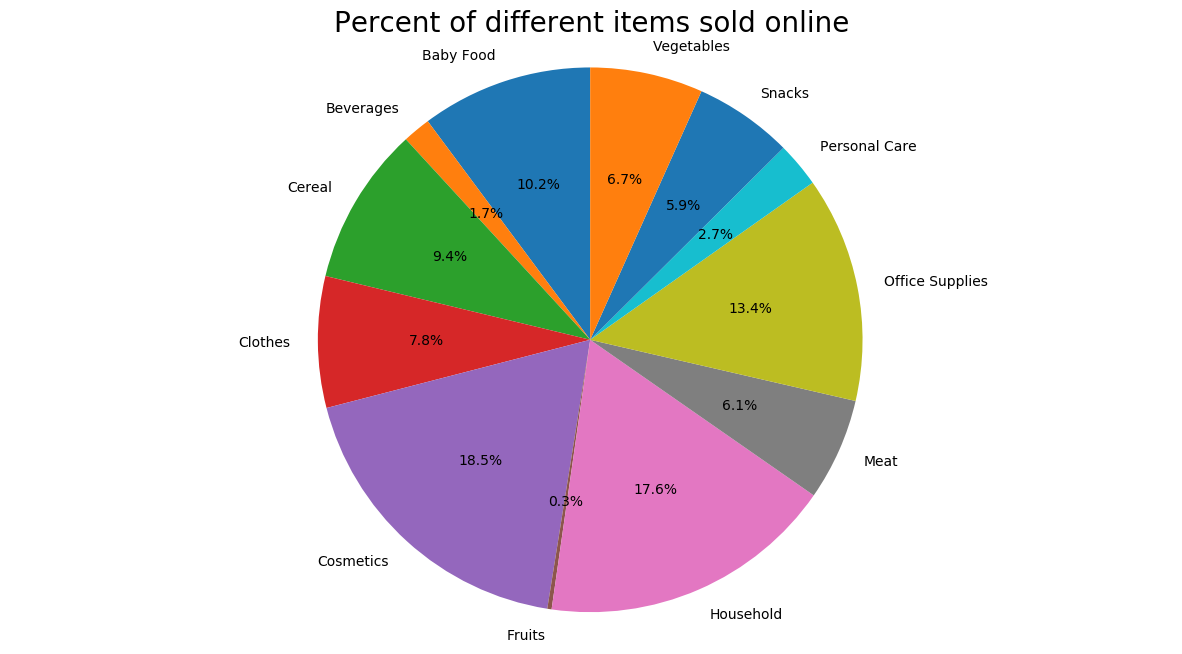

In [23]:
#Visulaization
fig = plt.figure(figsize=(15,8), dpi=100)
plt.pie(Online_sales['Profit'], labels=Online_sales['Item_Type'], autopct='%1.1f%%',
         startangle=90 )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percent of different items sold online" , fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Offline Sales of different items')

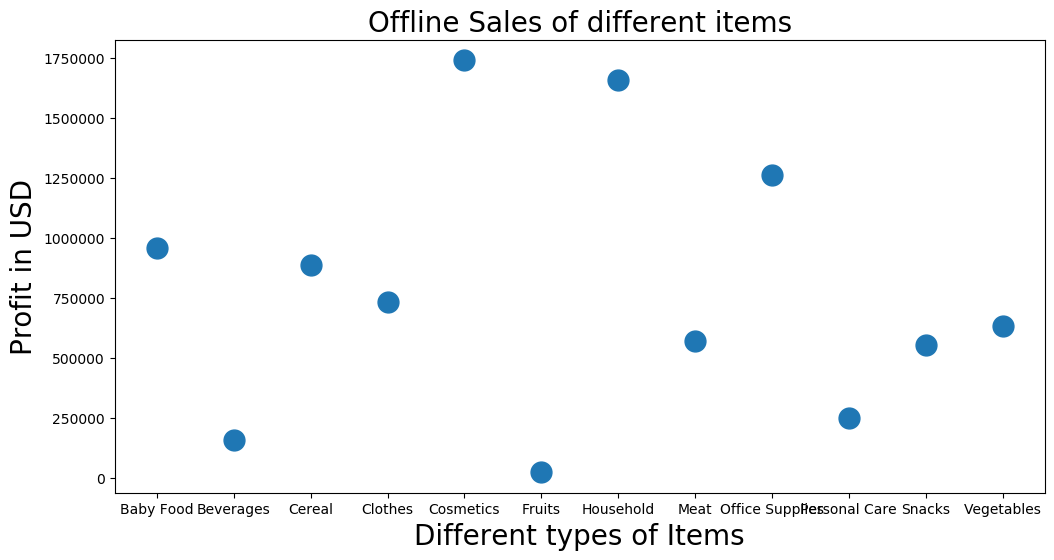

In [25]:
#Visualization
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot( Offline_sales['Item_Type'], Offline_sales['Profit'], 'o', markersize = 15)
plt.xlabel("Different types of Items", size = 20)
plt.ylabel("Profit in USD", size = 20)
plt.title("Offline Sales of different items" , fontsize = 20)

###### Total profit based on Order priority for North America region. 

In [26]:
#SQL Query 
Region_Item_priority = spark.sql("SELECT Order_Priority, sum(Total_Profit) as total_profit FROM par_Sales where Region='North America' GROUP BY Order_Priority ORDER BY 2 DESC")
Region_Item_priority.show()

+--------------+--------------------+
|Order_Priority|        total_profit|
+--------------+--------------------+
|             H|3.2664192750599995E9|
|             C|3.2364849875500007E9|
|             L|3.1815455767899995E9|
|             M|3.1047565680399995E9|
+--------------+--------------------+



In [27]:
#Converting to pandas dataframe
Priority = Region_Item_priority.toPandas()

In [28]:
#Setting index
Priority.set_index('Order_Priority', inplace=True)

(3100000000.0, 3300000000.0)

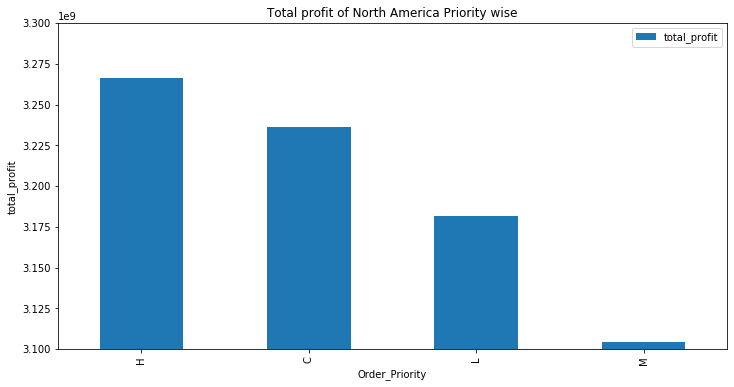

In [29]:
#Visulaization
Region_Item_priorityperRegion = Priority.plot(kind='bar',figsize=(12,6),rot = 90,title = "Total profit of North America Priority wise")
Region_Item_priorityperRegion.set_xlabel("Order_Priority")
Region_Item_priorityperRegion.set_ylabel("total_profit")
Region_Item_priorityperRegion.set_ylim(bottom = 3.1E9, top = 3.3E9)

###### Total profit per order priority per region

In [30]:
# SQL Query
Priority_per_region = spark.sql("SELECT Region, Order_Priority, sum(Total_Profit) as total_profit FROM par_Sales GROUP BY Region,Order_Priority ORDER BY 1 DESC")
Priority_per_region.show(30)

+--------------------+--------------+--------------------+
|              Region|Order_Priority|        total_profit|
+--------------------+--------------+--------------------+
|  Sub-Saharan Africa|             M|3.811891036107002E10|
|  Sub-Saharan Africa|             H|   3.822989010833E10|
|  Sub-Saharan Africa|             C|3.831342293604003E10|
|  Sub-Saharan Africa|             L|3.826010512261997E10|
|       North America|             L|3.1815455767899995E9|
|       North America|             C|3.2364849875500007E9|
|       North America|             H|3.2664192750599995E9|
|       North America|             M|3.1047565680399995E9|
|Middle East and N...|             M|1.820342400693001E10|
|Middle East and N...|             C|1.839737387067997...|
|Middle East and N...|             L|    1.82426361554E10|
|Middle East and N...|             H|1.825041011515999...|
|              Europe|             M|3.820709495300996E10|
|              Europe|             H|3.819803628242996E1

In [31]:
# Rows Count
Priority_per_region.count()

28

In [32]:
# Converting to pandas dataframe
Region_Priority = Priority_per_region.toPandas()

In [33]:
Region_Priority

,Region,Order_Priority,total_profit
0,Sub-Saharan Africa,M,3.811891e+10
1,Sub-Saharan Africa,C,3.831342e+10
2,Sub-Saharan Africa,H,3.822989e+10
3,Sub-Saharan Africa,L,3.826011e+10
4,North America,L,3.181546e+09
5,North America,C,3.236485e+09
6,North America,H,3.266419e+09
7,North America,M,3.104757e+09
8,Middle East and North Africa,M,1.820342e+10
9,Middle East and North Africa,H,1.825041e+10


In [34]:
Region_per_Priority = Region_Priority.pivot(index = 'Region', columns = 'Order_Priority', values = 'total_profit')

In [35]:
Region_per_Priority

Order_Priority,C,H,L,M
Region,,,,
Asia,2.141065e+10,2.143854e+10,2.142749e+10,2.155812e+10
Australia and Oceania,1.197852e+10,1.195612e+10,1.196510e+10,1.177042e+10
Central America and the Caribbean,1.589283e+10,1.589430e+10,1.601518e+10,1.582166e+10
Europe,3.818547e+10,3.819804e+10,3.807500e+10,3.820709e+10
Middle East and North Africa,1.839737e+10,1.825041e+10,1.824264e+10,1.820342e+10
North America,3.236485e+09,3.266419e+09,3.181546e+09,3.104757e+09
Sub-Saharan Africa,3.831342e+10,3.822989e+10,3.826011e+10,3.811891e+10


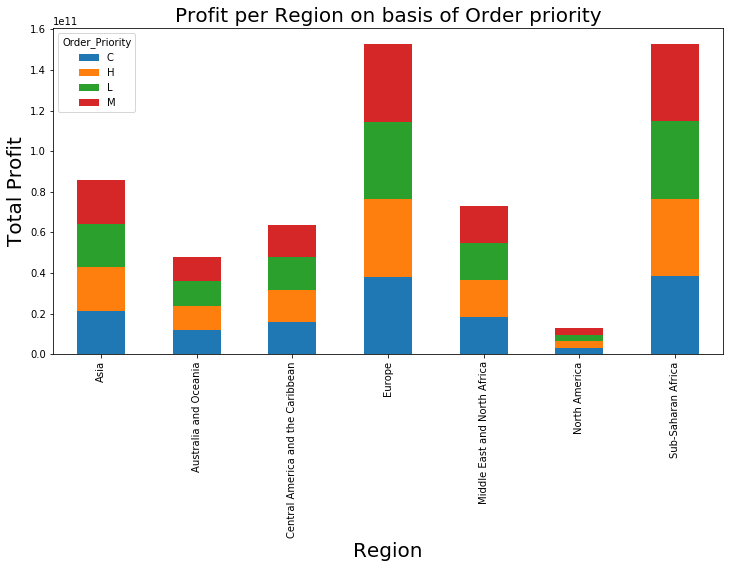

In [36]:
#Visualization
Region_per_priority1 = Region_per_Priority.plot(kind='bar', stacked=True, figsize=(12,6),
        title='Profit per Region on basis of Order priority')
Region_per_priority1.set_ylabel("Total Profit", size = 20)
Region_per_priority1.set_xlabel("Region", size = 20)
Region_per_priority1.title.set_size(20)

###### Total_Profit Month wise for North America. 

In [37]:
par_Sales.select('Order_Date').show()

+----------+
|Order_Date|
+----------+
|12/27/2010|
|  7/9/2011|
| 8/27/2013|
|  7/1/2016|
|  6/5/2016|
|11/19/2010|
| 4/27/2017|
| 5/14/2016|
| 3/31/2016|
| 1/30/2011|
|  1/4/2015|
| 12/4/2012|
| 4/23/2017|
| 5/26/2011|
|  8/3/2013|
| 1/13/2013|
|  5/2/2011|
| 2/15/2011|
|  5/6/2012|
|12/28/2015|
+----------+
only showing top 20 rows



In [38]:
# Creating seperate Month, Year and Day column.
par_Sales = par_Sales.withColumn('Month', split(par_Sales['Order_Date'], '/').getItem(0)) \
       .withColumn('day', split(par_Sales['Order_Date'], '/').getItem(1)) \
       .withColumn('Year', split(par_Sales['Order_Date'], '/').getItem(2)) 
par_Sales.show(truncate=False)

+----------------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+-----+---+----+
|Region                      |Country     |Item_Type      |Sales_Channel|Order_Priority|Order_Date|Order_ID |Ship_Date |Units_Sold|Unit_Price|Unit_Cost|Total_Revenue|Total_Cost|Total_Profit|Month|day|Year|
+----------------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+-----+---+----+
|Asia                        |Kyrgyzstan  |Baby Food      |Offline      |L             |12/27/2010|101368892|1/6/2011  |6163      |255.28    |159.42   |1573290.64   |982505.46 |590785.18   |12   |27 |2010|
|Asia                        |China       |Clothes        |Offline      |M             |7/9/2011  |680699002|7/19/2011 |2816      |109.28    |35.84    |307732.48    |100925.44 

In [39]:
# Updating Month column with month names 
par_Sales = par_Sales.withColumn('Month',when(par_Sales['Month'] == 1, 'January')  
                                    .when(par_Sales['Month'] == 2, 'February') 
                                    .when(par_Sales['Month'] == 3, 'March') 
                                    .when(par_Sales['Month'] == 4, 'April') 
                                    .when(par_Sales['Month'] == 5, 'May') 
                                    .when(par_Sales['Month'] == 6, 'June') 
                                    .when(par_Sales['Month'] == 7, 'July') 
                                    .when(par_Sales['Month'] == 8, 'August') 
                                    .when(par_Sales['Month'] == 9, 'September') 
                                    .when(par_Sales['Month'] == 10, 'October') 
                                    .when(par_Sales['Month'] == 11, 'November') 
                                    .when(par_Sales['Month'] == 12, 'December') 
                                    .otherwise('Null'))
                

In [40]:
par_Sales.show()

+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+--------+---+----+
|              Region|     Country|      Item_Type|Sales_Channel|Order_Priority|Order_Date| Order_ID| Ship_Date|Units_Sold|Unit_Price|Unit_Cost|Total_Revenue|Total_Cost|Total_Profit|   Month|day|Year|
+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+--------+---+----+
|                Asia|  Kyrgyzstan|      Baby Food|      Offline|             L|12/27/2010|101368892|  1/6/2011|      6163|    255.28|   159.42|   1573290.64| 982505.46|   590785.18|December| 27|2010|
|                Asia|       China|        Clothes|      Offline|             M|  7/9/2011|680699002| 7/19/2011|      2816|    109.28|    35.84|    307732.48| 100925.44|   206807.04|    July|  9|2

In [41]:
par_Sales.columns

['Region',
 'Country',
 'Item_Type',
 'Sales_Channel',
 'Order_Priority',
 'Order_Date',
 'Order_ID',
 'Ship_Date',
 'Units_Sold',
 'Unit_Price',
 'Unit_Cost',
 'Total_Revenue',
 'Total_Cost',
 'Total_Profit',
 'Month',
 'day',
 'Year']

In [42]:
# Updatind the vew again
par_Sales.createOrReplaceTempView("par_Sales")

In [43]:
#SQL Query
Profit_per_month = spark.sql("SELECT Month, sum(Total_Profit) as Total_Profit FROM par_Sales WHERE Year = '2017' GROUP BY Month ORDER BY 2 ASC")
Profit_per_month.show()

+--------+-------------------+
|   Month|       Total_Profit|
+--------+-------------------+
|February|5.916011445650001E9|
|    July|6.143288995380002E9|
|    June|    6.38361831888E9|
|   April|     6.4564019358E9|
| January|6.584217626599998E9|
|   March|6.601035163350001E9|
|     May|    6.62534195132E9|
+--------+-------------------+



In [44]:
# Convertong to pandas dataframe
Monthly_profit = Profit_per_month.toPandas()

In [45]:
# Setting index to dataframe
Monthly_profit.set_index('Month', inplace=True)

Text(0, 0.5, 'Total profit in USD')

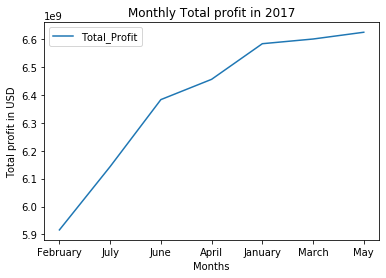

In [46]:
# Visualization
Monthly_profit_visz = Monthly_profit.plot(kind='line',rot = 0,title = "Monthly Total profit in 2017")
Monthly_profit_visz.set_xlabel("Months")
Monthly_profit_visz.set_ylabel("Total profit in USD")

##### The END